In [1]:
"""
TIP: 
    1. Never use  [[0]*3]*3 for array assignment - This creates three duplicate list. Check out below code to view the weird result it gives:
        X = [[2]*3]*2
        X[0][0] = 3
        print(X)
        #Extremely weired!!! This is assigning to all the coloumn 0th element to 3.
"""
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import *

#TODO: Take input from the user
N = 2                  # Number of oscillators;
NEPOCHS = 200000         # Duration to run
DT = 0.01             # Time step between each epoch
    
#Constants
DEBUG = 1
MU = 1                   # Oscillator parameter (>0 for supercritical)
EPS = 0.9                # ε - coupling strength for error signal e(t) = D(t) - P(t)
ETA_OMEGA = 0.1         #ηω - ωi' = -ηω*e(t)*sin(Фi) ; 1/η = 0.0001
TAU = 10000             #10000, τ - τ*Wij' = -Wij + zi(zj*)^(ωi/ωj)
#ETA_OMEGA = 0.0001;     #these params are critical eta_omega = 0.0001

#Initialized at startup
R = np.zeros([N, 1])          # R vector in polar coordinates for N oscillators
PHI = np.zeros([N, 1])        # Ф vector for N oscillators
OMEGA = np.zeros([N, 1])      # Natural frequencies of N oscillators
A = np.zeros([N, N])          # NxN connectivity matrix for N oscillators
THETA = np.zeros([N, N])      # NxN phase angle difference in complex coupling
ALPHA = np.zeros([N, 1])      # NxN weight matrix for phase 1 teaching
IEXT = np.zeros([N, 3])       # For each oscillator external input freq, phase and amplitude

def initialize(N):
    """
    Parameters:
    R:     Initialize everything to 1
    PHI:   2*pi*rand(n, 1) - Uniformly distributed random number from 0 - 2ℼ 
    W:     { 0.01 + 45*2*pi*rand(n,1) - Given} For now assign in steps of 5
    A:     Randomly assign betwwn 0-1 uniformly distributed (TODO: constrain this later)
    THETA: Randomly assign between 0 - 2ℼ uniformly distributed
    APLHA: Initialize all to 0.09
    
    Constrain:
    θ12 = -θ21 = θ
    A12 = A21 = A
    MU = 1
    
    Return: 
    R, PHI, W, A, THETA
    
    Use coloumn vector to avoid ambiguity
    """
    R = 2*np.ones([N, 1]) 
    R[0] = 0.5
    R[1] = 2
    PHI = 2*pi*np.random.rand(N, 1)
    #PHI[0] = 3.7008 #Delete me
    #PHI[1] = 2.3106 #Delete me
    PHI[0] = 1.2046 #Delete me
    PHI[1] = 2.7008 #Delete me
    OMEGA = np.array([7 + i*5 for i in range(N)])
    OMEGA = OMEGA[:,None] #Converting to coloumn vector
    print("OMEGA \n", OMEGA)
    print("PHI \n", PHI)
    
    """
        (i) Aij = Aji (ii) Aii = 0
        (ii) θ12 = -θ21 = θ
        Note: Make sure Aii is always zero to avoid numerical issues
    """
    A = np.random.rand(N, 1)
    A = np.dot(A, A.T)
    #A.fill(0.05) #Delete me
    A.fill(0.0001)
    np.fill_diagonal(A, 0)
    print("A \n", A)
    
    THETA = 2*pi*np.random.rand(N, N)
    THETA = (THETA - THETA.T)
    #THETA[0][1] = 1.8968 #Delete me
    #THETA[1][0] = -1.8968 #Delete me
    #THETA[0][1] = 1.657 #Delete me
    #THETA[1][0] = -1.657 #Delete me
    #THETA[0][1] =  -2.513 #Delete me
    #THETA[1][0] =  2.513 #Delete me
    THETA[0][1] =  -1.7884 #Delete me
    THETA[1][0] =  1.7884 #Delete me
    print("THETA \n", THETA)
    
    ALPHA = np.ones([N, 1]) #0.09*
    IEXT[:,0] = 1                                           #All external input componets have same amplitude
    IEXT[:,1] = np.array([5 + i*5 for i in range(N)])       #Also try setting frequency as that of oscillator itself
    IEXT[:,2] = np.array([pi/4, pi/6])                      #Intially setting phase difference to zero. Later set it to some non zero values
    #IEXT[:,2] = np.array([pi/4 + i*(pi/4) for i in range(N)])
    print("IEXT \n", IEXT)
    
    #Convert everythint to coloumn vector
    return R, PHI, OMEGA, A, THETA, ALPHA, IEXT
    

In [2]:
def truncated_remainder(dividend, divisor):
    divided_number = dividend / divisor
    divided_number = \
        -int(-divided_number) if divided_number < 0 else int(divided_number)

    remainder = dividend - divisor * divided_number

    return remainder

def transform_to_pipi(input_angle):
    revolutions = int((input_angle + np.sign(input_angle) * pi) / (2 * pi))

    p1 = truncated_remainder(input_angle + np.sign(input_angle) * pi, 2 * pi)
    p2 = (np.sign(np.sign(input_angle)
                  + 2 * (np.sign(fabs((truncated_remainder(input_angle + pi, 2 * pi))
                                      / (2 * pi))) - 1))) * pi

    output_angle = p1 - p2

    return output_angle, revolutions

In [3]:
#TODO: write model here
def model(N, R, PHI, OMEGA, A, THETA, ALPHA, IEXT, NEPOCHS):
    """
    Parameters:
    NEPOCHS: How long to run the model
    
    TODO: Later add Iext as well
    
    Return:
    W: Change in W
    PHI: Change in pahse
    N_PHI_DIFF: Normalized pahse difference
    
    Miscellaneous:
        1. Normalized pahse difference approaches zero ss individual oscillators attain equillibrium 
        2. No dynamics for Amplitude of lateral coupling i.e. dA = 0
    """
    # Be careful while changing these assignment!! Check out TIP section
    N_PHI_DIFF = np.zeros([N, N, NEPOCHS]) 
    PHI_ = np.zeros([N, NEPOCHS])
    R_ = np.zeros([N, NEPOCHS])
    OMEGA_ = np.zeros([N, NEPOCHS])
    THETA_ = np.zeros([N, N, NEPOCHS])
    OI_PHASE_DIFF = np.zeros([N, NEPOCHS])
    EXTERNAL_INPUTS = np.zeros([N, NEPOCHS])
    DUMMY = np.zeros(NEPOCHS) #Only for N=2
    
    #COMPLEX_W = A*np.exp(1j*THETA/OMEGA.T) #check
    
    #Dummy for handling weights in complex form
    #COMPLEX_W = np.np.zeros([N, N])
    
    ##S = np.zeros(NEPOCHS) #signal 
    ##ERR = np.zeros(NEPOCHS)
    #IEXT: contains n external signal of different amplitude, frequency and phase
    
    for t in range(NEPOCHS):
        # Why are they initializing R and THETA in every epoch?
        
        ##S[t] = np.sum(ALPHA*np.cos(PHI))
        ##ERR[t] = PTEACH[t] - S[t]
        
        """
            1. Vector form - do simultaneous update 
            2. Below system handles complex sinusiodal input
            3. In all matrix rows contain source oscillator, and 
               columns represent coupling to corresponding target oscillator
               
            Caution:
            Use coloumn vector for each oscillator to avoid confusion
        """
        #print("Interaction matrix \n", A)
        #print("Frequency \n", OMEGA)
        #print("Phase phi\n", PHI)
        
        NORM_FREQ = np.multiply(OMEGA, 1/OMEGA.T) #Check #ith row contains ωi/ωj
        NORM_FREQ[np.isnan(NORM_FREQ)] = 0
        NORM_PHASE = (PHI/OMEGA).T - (PHI/OMEGA) + THETA/(OMEGA*OMEGA.T) #Check #Nij = ∅j/ωj - ∅i/ωi + θij/ωiωj
        #To be used for training lateral weights Nij 
        # ∅i/ωi - ∅j/ωj - θij/ωiωj
        PHASE_DIFF = (PHI/OMEGA) - (PHI/OMEGA).T - THETA/(OMEGA*OMEGA.T) #Check
        
        """
            Causes of NaN
            1. Negative entries in R matrix. Any negative entry in R results in NaN i.e. complex value
        """
        R_POW_NF = np.power(R.T, NORM_FREQ) #!!!!!!!!!!!Wrong #ith row contains Rj^(ωi/ωj) 
        
        Amplitude = IEXT[:,0][:,None] #check
        Freq = IEXT[:,1][:,None] #check
        Phase = IEXT[:,2][:,None] #check
        
        dOMEGA = -ETA_OMEGA*Amplitude*np.sin( PHI - Freq*DT*t - Phase)*DT
        
        #Equation1
        #Make input real valued
        I_CMPLX = Amplitude*np.exp(1j*( Freq*DT*t + Phase )) #Amplitude*np.sin(Freq*DT*t + Phase) #
        Z_CMPLX = R*np.exp(1j*PHI)
        
        Term1 = Z_CMPLX*(MU + 1j*OMEGA - np.absolute(Z_CMPLX)**2)
        Term2 = np.sum(A*np.exp(1j*( THETA/OMEGA.T ))*np.power(Z_CMPLX.T, OMEGA/OMEGA.T), axis=1)[:,None]
        Term3 = 0 #EPS*I_CMPLX
        
        dZ_CMPLX = (Term1 + Term2 + Term3)*DT
        Z_CMPLX = Z_CMPLX + dZ_CMPLX
        
        #Equation2
        COMPLEX_W = A*np.exp(1j*THETA/OMEGA.T) #check
        Z1 = R*np.exp(1j*PHI) #Check
        Z2 = R.T*np.exp(-1j*PHI.T) #Check
        Z2_SP = np.power(Z2, OMEGA/OMEGA.T) #Check
        
        dCOMPLEX_W = (-COMPLEX_W + Z1*Z2_SP)
        COMPLEX_W = COMPLEX_W + dCOMPLEX_W/TAU
        
        #Setting Aij
        #A = R*R_POW_NF*np.cos(ARG_2)
        
        #Phase diff b/w oscillator and Iext. Ignore if Iext is zero
        I_EXT_PHASE = Freq*DT*t + Phase
        OSC_PHASE = PHI
        
        #print(1/0)
        
        R = np.absolute(Z_CMPLX)
        PHI = np.angle(Z_CMPLX)
        #OMEGA = OMEGA + dOMEGA
        THETA = np.angle(COMPLEX_W)*OMEGA.T
        
        #R = R + dR
        #PHI = PHI + dPHI
        #OMEGA = OMEGA + dOMEGA
        #THETA = THETA + dTHETA/TAU
        
        #if t==(NEPOCHS-1):
        #    print(1/0)
        
        """
            Corrections:
            1. Non-negative oscillator frequencies
            2. Entries in R mtrix should not be negative
        """
        OMEGA[OMEGA < 0.01] = 0.01 #Restrict frequencies of oscillator to positive range only
        R[R < 0.01] = 0.01         #This avoids NaN restricting R to non-negative values
        np.fill_diagonal(THETA, 0) #This avoids NaN due to 'A' term in the denominator in dTHETA
        np.fill_diagonal(A, 0)
        
        R_[:,t] = R.T
        PHI_[:,t] = PHI.T
        OMEGA_[:,t] = OMEGA.T
        N_PHI_DIFF[:,:,t] = NORM_PHASE
        THETA_[:,:,t] = THETA
        OI_PHASE_DIFF[:,t] = (I_EXT_PHASE - OSC_PHASE).T
        EXTERNAL_INPUTS[:,t] = (Amplitude*np.cos(I_EXT_PHASE)).T #Plotting only real part of the signal
        
    return R, PHI, R_, PHI_, OMEGA_, N_PHI_DIFF, THETA_, OI_PHASE_DIFF, EXTERNAL_INPUTS#, DUMMY

OMEGA 
 [[ 7]
 [12]]
PHI 
 [[1.2046]
 [2.7008]]
A 
 [[0.     0.0001]
 [0.0001 0.    ]]
THETA 
 [[ 0.     -1.7884]
 [ 1.7884  0.    ]]
IEXT 
 [[ 1.          5.          0.78539816]
 [ 1.         10.          0.52359878]]


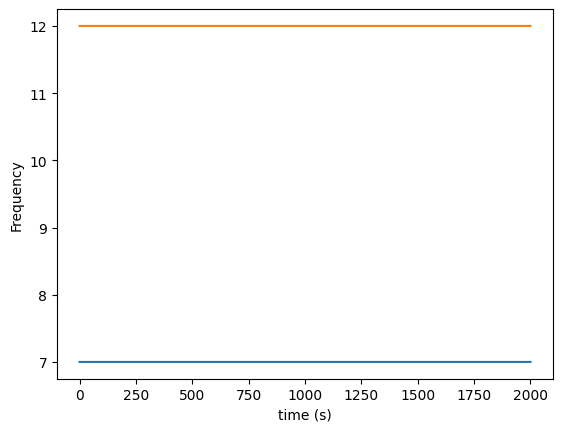

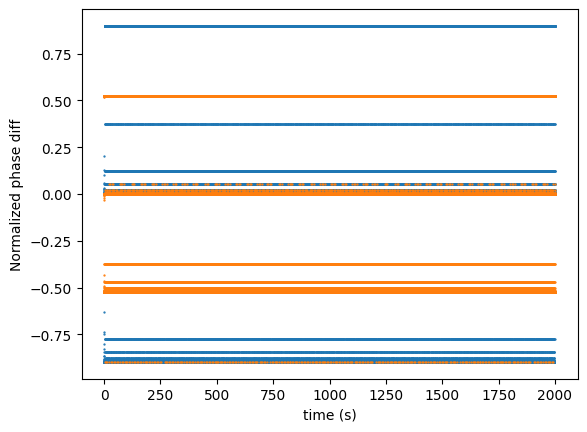

N Phase 2.8183944883609924e-05
N Phase -2.605378132299052e-05
N Phase * omega 0.00019728761418526947
N Phase * omega -0.00031264537587588626


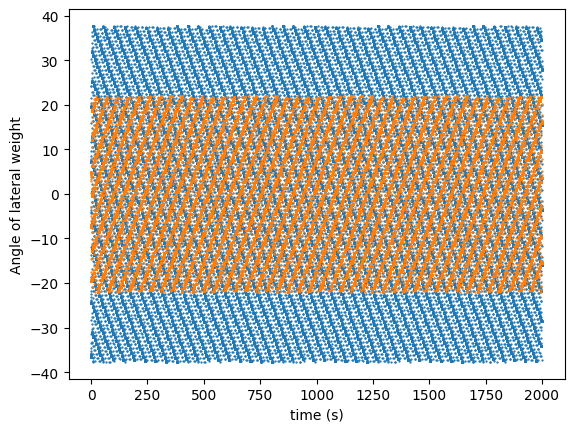


 Diff:  -7.142686685155316

 Theta -3.5712538757291576 3.5714328094261583

 Omega 12.0 7.0


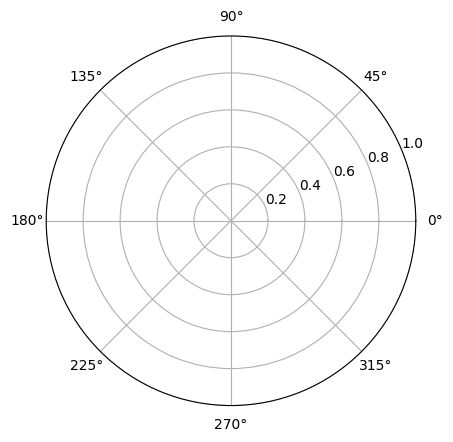

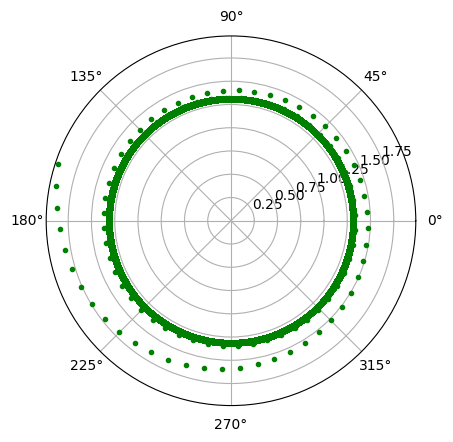

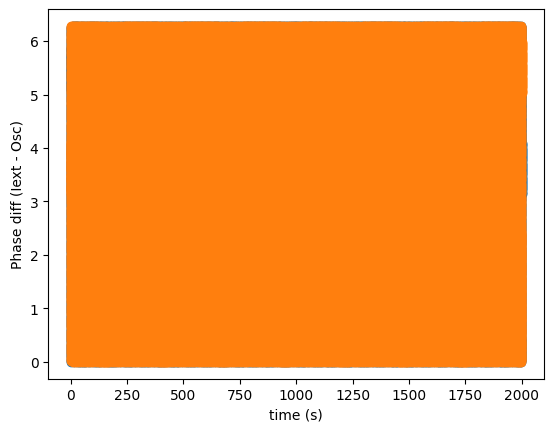

In [5]:
R, PHI, OMEGA, A, THETA, ALPHA, IEXT = initialize(N)
R, PHI, R_, PHI_, OMEGA_, N_PHI_DIFF, THETA_, OI_PHASE_DIFF, EXTERNAL_INPUTS = model(N, R, PHI, OMEGA, A, THETA, ALPHA, IEXT, NEPOCHS)

t = np.multiply([i for i in range(NEPOCHS)], DT)
X = [np.multiply(R_[i], np.cos(PHI_[i])) for i in range(N)] 

# for i in range(len(X)):
#     f = plt.figure()
#     f.set_figwidth(10)
#     f.set_figheight(2)
    
#     plt.xlabel("time (s)")
#     plt.ylabel("Amplitude")
#     plt.plot(t, X[i])
#     plt.plot(t, EXTERNAL_INPUTS[i])
#     plt.legend(['Osc', 'Iext'])
#     plt.show()

plt.xlabel("time (s)")
plt.ylabel("Frequency")
for i in range(len(X)):
    plt.plot(t, OMEGA_[i])
plt.show()

plt.xlabel("time (s)")
plt.ylabel("Normalized phase diff")
for i in range(N):
    for j in range(N):
        if i != j:
            #Temp = N_PHI_DIFF[i][j]*OMEGA_[i]
            #Temp = np.where(Temp < 0, Temp%(-2*pi), Temp%(2*pi))
            #Temp = np.where(Temp > pi, Temp-2*pi, Temp)
            #Temp = np.where(Temp < -pi, Temp+2*pi, Temp)
            #N_PHI_DIFF[i][j] = Temp/OMEGA_[i]
            plt.scatter(t, N_PHI_DIFF[i][j], s=0.4)
plt.show()

print("N Phase", N_PHI_DIFF[0][1][NEPOCHS-1])
print("N Phase", N_PHI_DIFF[1][0][NEPOCHS-1])
print("N Phase * omega", N_PHI_DIFF[0][1][NEPOCHS-1]*OMEGA_[0][NEPOCHS-1])
print("N Phase * omega", N_PHI_DIFF[1][0][NEPOCHS-1]*OMEGA_[1][NEPOCHS-1])

plt.xlabel("time (s)")
plt.ylabel("Angle of lateral weight")
for i in range(N):
    for j in range(N):
        if i != j:
            #Temp = THETA_[i][j]/OMEGA_[j]
            #Temp = np.where(Temp < 0, Temp%(-2*pi), Temp%(2*pi))
            #Temp = np.where(Temp > pi, Temp-2*pi, Temp)
            #Temp = np.where(Temp < -pi, Temp+2*pi, Temp)
            #THETA_[i][j] = Temp*OMEGA_[j]
            plt.scatter(t, THETA_[i][j], s=0.4)
plt.show()

print("\n Diff: ", THETA_[0][1][NEPOCHS-1] - THETA_[1][0][NEPOCHS-1])

output_angle1, revolutions1 = transform_to_pipi( THETA_[0][1][NEPOCHS-1]/OMEGA_[1][NEPOCHS-1] )
output_angle2, revolutions2 = transform_to_pipi( THETA_[1][0][NEPOCHS-1]/OMEGA_[0][NEPOCHS-1] )

print("\n Theta", THETA_[0][1][NEPOCHS-1], THETA_[1][0][NEPOCHS-1] )
#print("\n Theta", output_angle1*OMEGA_[1][NEPOCHS-1], output_angle2*OMEGA_[0][NEPOCHS-1] )
print("\n Omega", OMEGA_[1][NEPOCHS-1], OMEGA_[0][NEPOCHS-1])
# print("\n", (2*pi*OMEGA_[1][NEPOCHS-1]))
# Temp = THETA_[0][1][NEPOCHS-1]/(2*pi*OMEGA_[1][NEPOCHS-1])
# print("\n", Temp)
# Temp = THETA_[0][1][NEPOCHS-1]%(2*pi*OMEGA_[1][NEPOCHS-1])
# #Temp = THETA_[0][1][NEPOCHS-1] - Temp*(2*pi*OMEGA_[1][NEPOCHS-1])
# print("\n", Temp)

plt.axes(projection = 'polar')
for i in range(N):
    plt.polar(PHI_[i], R_[i], 'g.')
    plt.show()

#Phase difference between Iext and Oscillator
plt.xlabel("time (s)")
plt.ylabel("Phase diff (Iext - Osc)")
for i in range(len(X)):
    plt.scatter(t, OI_PHASE_DIFF[i]%(2*pi))
plt.show()


In [ ]:
%debug

> /tmp/ipykernel_567679/1761679890.py(11)transform_to_pipi()
      9 
     10 def transform_to_pipi(input_angle):
---> 11     revolutions = int((input_angle + np.sign(input_angle) * pi) / (2 * pi))
     12 
     13     p1 = truncated_remainder(input_angle + np.sign(input_angle) * pi, 2 * pi)

